The goal of this competition is to detect external contact experienced by players during an NFL football game. I will use video and player tracking data to identify moments with contact to help improve player safety.

The National Football League (NFL) has teamed up with Amazon Web Services (AWS) to strengthen its commitment to predict player injuries. The NFL aspires to have the best injury surveillance and mitigation program in any sport. With your machine learning and computer vision skills, you can help the NFL accurately identify when players experience contact throughout a football play.

In prior years, the NFL challenged the Kaggle community to create helmet impact detection and identification algorithms. This year the NFL looks to automatically identify all moments when players experience contact. This competition will be successful if we can reliably detect moments when players are in contact with one another and when a player’s body is in contact with the ground.

Currently, the NFL uses its tracking system to monitor a large number of statistics about players’ load during the season. The league has a solution that predicts contact between players, but it only leverages the player tracking data. This competition hopes to improve the predictive power by including video in addition to tracking data. Categorizing ground contact will also provide a more comprehensive view of impacts, improving analysis for player health and safety.

More accurate data is an important step toward the NFL’s injury surveillance and mitigation goals. With complete contact detection, the league can identify correlations between certain types of contact and injury, a contributor to future prevention. My efforts could help mitigate unsafe situations to reduce injury to all players.

The National Football League is America's most popular sports league. Founded in 1920, the NFL developed the model for the successful modern sports league and is committed to advancing progress in the diagnosis, prevention, and treatment of sports-related injuries. This competition is part of the Digital Athlete, a joint effort between the NFL and AWS to build a virtual, 360-degree representation of an NFL player’s experience. The Digital Athlete hopes to generate a precise picture of what they need when it comes to preventing and recovering from injuries while performing at their best. Health and safety efforts include support for independent medical research and engineering advancements as well as a commitment to work to better protect players and make the game safer, including enhancements to medical protocols and improvements to how our game is taught and played. 

For more information about the NFL's health and safety efforts, please visit the NFL Player Health and Safety website.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nfl-exp1/resnet50_fold0.pt
/kaggle/input/timm-0-6-9/pytorch-image-models-master/train.py
/kaggle/input/timm-0-6-9/pytorch-image-models-master/inference.py
/kaggle/input/timm-0-6-9/pytorch-image-models-master/clean_checkpoint.py
/kaggle/input/timm-0-6-9/pytorch-image-models-master/setup.cfg
/kaggle/input/timm-0-6-9/pytorch-image-models-master/LICENSE
/kaggle/input/timm-0-6-9/pytorch-image-models-master/hubconf.py
/kaggle/input/timm-0-6-9/pytorch-image-models-master/.gitignore
/kaggle/input/timm-0-6-9/pytorch-image-models-master/README.md
/kaggle/input/timm-0-6-9/pytorch-image-models-master/benchmark.py
/kaggle/input/timm-0-6-9/pytorch-image-models-master/distributed_train.sh
/kaggle/input/timm-0-6-9/pytorch-image-models-master/requirements-docs.txt
/kaggle/input/timm-0-6-9/pytorch-image-models-master/model-index.yml
/kaggle/input/timm-0-6-9/pytorch-image-models-master/MANIFEST.in
/kaggle/input/timm-0-6-9/pytorch-image-models-master/requirements.txt
/kaggle/input/timm-0-6-9

In [2]:
import os
import sys
sys.path.append('/kaggle/input/timm-0-6-9/pytorch-image-models-master')
import glob
import random
import math
import gc
import cv2
from tqdm import tqdm
import time
from functools import lru_cache
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef

In [3]:
CFG = {
    'seed': 42,
    'model': 'resnet50',
    'img_size': 256,
    'epochs': 10,
    'train_bs': 100, 
    'valid_bs': 64,
    'lr': 1e-3, 
    'weight_decay': 1e-6,
    'num_workers': 2
}

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['seed'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
def expand_contact_id(df):
    """
    Splits out contact_id into seperate columns.
    """
    df["game_play"] = df["contact_id"].str[:12]
    df["step"] = df["contact_id"].str.split("_").str[-3].astype("int")
    df["nfl_player_id_1"] = df["contact_id"].str.split("_").str[-2]
    df["nfl_player_id_2"] = df["contact_id"].str.split("_").str[-1]
    return df

In [6]:
labels = expand_contact_id(pd.read_csv("/kaggle/input/nfl-player-contact-detection/sample_submission.csv"))

test_tracking = pd.read_csv("/kaggle/input/nfl-player-contact-detection/test_player_tracking.csv")

test_helmets = pd.read_csv("/kaggle/input/nfl-player-contact-detection/test_baseline_helmets.csv")

test_video_metadata = pd.read_csv("/kaggle/input/nfl-player-contact-detection/test_video_metadata.csv")
gc.collect()

0

In [7]:
!mkdir -p ../work/frames

for video in tqdm(test_helmets.video.unique()):
    if 'Endzone2' not in video:
        !ffmpeg -i /kaggle/input/nfl-player-contact-detection/test/{video} -q:v 2 -f image2 /kaggle/work/frames/{video}_%04d.jpg -hide_banner -loglevel error

100%|██████████| 4/4 [00:45<00:00, 11.37s/it]


In [8]:
def create_features(df, tr_tracking, merge_col="step", use_cols=["x_position", "y_position"]):
    output_cols = []
    df_combo = (
        df.astype({"nfl_player_id_1": "str"})
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id",] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_1"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .rename(columns={c: c+"_1" for c in use_cols})
        .drop("nfl_player_id", axis=1)
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id"] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_2"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .drop("nfl_player_id", axis=1)
        .rename(columns={c: c+"_2" for c in use_cols})
        .sort_values(["game_play", merge_col, "nfl_player_id_1", "nfl_player_id_2"])
        .reset_index(drop=True)
    )
    output_cols += [c+"_1" for c in use_cols]
    output_cols += [c+"_2" for c in use_cols]
    
    if ("x_position" in use_cols) & ("y_position" in use_cols):
        index = df_combo['x_position_2'].notnull()
        
        distance_arr = np.full(len(index), np.nan)
        tmp_distance_arr = np.sqrt(
            np.square(df_combo.loc[index, "x_position_1"] - df_combo.loc[index, "x_position_2"])
            + np.square(df_combo.loc[index, "y_position_1"]- df_combo.loc[index, "y_position_2"])
        )
        
        distance_arr[index] = tmp_distance_arr
        df_combo['distance'] = distance_arr
        output_cols += ["distance"]
        
    df_combo['G_flug'] = (df_combo['nfl_player_id_2']=="G")
    output_cols += ["G_flug"]
    return df_combo, output_cols
gc.collect()

0

In [9]:
use_cols = [
    'x_position', 'y_position', 'speed', 'distance',
    'direction', 'orientation', 'acceleration', 'sa'
]

test, feature_cols = create_features(labels, test_tracking, use_cols=use_cols)
test

contact_id  contact     game_play  step  \
0        58168_003392_0_37084_37211        0  58168_003392     0   
1        58168_003392_0_37084_38556        0  58168_003392     0   
2        58168_003392_0_37084_38567        0  58168_003392     0   
3        58168_003392_0_37084_38590        0  58168_003392     0   
4        58168_003392_0_37084_39947        0  58168_003392     0   
...                             ...      ...           ...   ...   
49583  58172_003247_125_52521_52939        0  58172_003247   125   
49584      58172_003247_125_52521_G        0  58172_003247   125   
49585  58172_003247_125_52852_52939        0  58172_003247   125   
49586      58172_003247_125_52852_G        0  58172_003247   125   
49587      58172_003247_125_52939_G        0  58172_003247   125   

      nfl_player_id_1 nfl_player_id_2  x_position_1  y_position_1  speed_1  \
0               37084           37211         41.90         20.08     0.54   
1               37084           38556         41.90         20.08     0.54   
2               37084           38567         41.90         20.08     0.54   
3               37084           38590         41.90         20.08     0.54   
4               37084           39947         41.90         20.08     0.54   
...               ...             ...           ...           ...      ...   
49583           52521           52939         23.44          4.04     1.41   
49584           52521               G         23.44          4.04     1.41   
49585           52852           52939         32.67          2.18     2.34   
49586           52852               G         32.67          2.18     2.34   
49587           52939               G         37.94          2.10     2.29   

       distance_1  ...  x_position_2  y_position_2  speed_2  distance_2  \
0            0.06  ...         39.59         17.07     0.53        0.05   
1            0.06  ...         41.93         30.61     0.67        0.05   
2            0.06  ...         40.37         19.88     0.66        0.07   
3            0.06  ...         40.33         25.28     0.52        0.06   
4            0.06  ...         40.11         26.73     0.99        0.09   
...           ...  ...           ...           ...      ...         ...   
49583        0.15  ...         37.94          2.10     2.29        0.24   
49584        0.15  ...           NaN           NaN      NaN         NaN   
49585        0.24  ...         37.94          2.10     2.29        0.24   
49586        0.24  ...           NaN           NaN      NaN         NaN   
49587        0.24  ...           NaN           NaN      NaN         NaN   

       direction_2  orientation_2  acceleration_2  sa_2   distance  G_flug  
0           134.84          84.73            1.43  1.42   3.794232   False  
1           232.50         227.00            1.82  1.61  10.530043   False  
2           136.70          88.92            0.90  0.89   1.543017   False  
3           141.08         100.37            0.59  0.58   5.431841   False  
4           163.38          90.69            1.68  1.64   6.886697   False  
...            ...            ...             ...   ...        ...     ...  
49583       211.73         215.11            2.43 -2.43  14.629204   False  
49584          NaN            NaN             NaN   NaN        NaN    True  
49585       211.73         215.11            2.43 -2.43   5.270607   False  
49586          NaN            NaN             NaN   NaN        NaN    True  
49587          NaN            NaN             NaN   NaN        NaN    True  

[49588 rows x 24 columns]

In [10]:
test_filtered = test.query('not distance>2').reset_index(drop=True)
test_filtered['frame'] = (test_filtered['step']/10*59.94+5*59.94).astype('int')+1
test_filtered

contact_id  contact     game_play  step nfl_player_id_1  \
0     58168_003392_0_37084_38567        0  58168_003392     0           37084   
1         58168_003392_0_37084_G        0  58168_003392     0           37084   
2     58168_003392_0_37211_46445        0  58168_003392     0           37211   
3         58168_003392_0_37211_G        0  58168_003392     0           37211   
4         58168_003392_0_38556_G        0  58168_003392     0           38556   
...                          ...      ...           ...   ...             ...   
6626    58172_003247_125_48241_G        0  58172_003247   125           48241   
6627    58172_003247_125_48335_G        0  58172_003247   125           48335   
6628    58172_003247_125_52521_G        0  58172_003247   125           52521   
6629    58172_003247_125_52852_G        0  58172_003247   125           52852   
6630    58172_003247_125_52939_G        0  58172_003247   125           52939   

     nfl_player_id_2  x_position_1  y_position_1  speed_1  distance_1  ...  \
0              38567         41.90         20.08     0.54        0.06  ...   
1                  G         41.90         20.08     0.54        0.06  ...   
2              46445         39.59         17.07     0.53        0.05  ...   
3                  G         39.59         17.07     0.53        0.05  ...   
4                  G         41.93         30.61     0.67        0.05  ...   
...              ...           ...           ...      ...         ...  ...   
6626               G         33.86         -1.28     0.79        0.08  ...   
6627               G         44.74          3.16     4.72        0.48  ...   
6628               G         23.44          4.04     1.41        0.15  ...   
6629               G         32.67          2.18     2.34        0.24  ...   
6630               G         37.94          2.10     2.29        0.24  ...   

      y_position_2  speed_2  distance_2  direction_2  orientation_2  \
0            19.88     0.66        0.07       136.70          88.92   
1              NaN      NaN         NaN          NaN            NaN   
2            18.08     1.10        0.10       148.93          92.39   
3              NaN      NaN         NaN          NaN            NaN   
4              NaN      NaN         NaN          NaN            NaN   
...            ...      ...         ...          ...            ...   
6626           NaN      NaN         NaN          NaN            NaN   
6627           NaN      NaN         NaN          NaN            NaN   
6628           NaN      NaN         NaN          NaN            NaN   
6629           NaN      NaN         NaN          NaN            NaN   
6630           NaN      NaN         NaN          NaN            NaN   

      acceleration_2  sa_2  distance  G_flug  frame  
0               0.90  0.89  1.543017   False    300  
1                NaN   NaN       NaN    True    300  
2               2.03  2.03  1.258014   False    300  
3                NaN   NaN       NaN    True    300  
4                NaN   NaN       NaN    True    300  
...              ...   ...       ...     ...    ...  
6626             NaN   NaN       NaN    True   1049  
6627             NaN   NaN       NaN    True   1049  
6628             NaN   NaN       NaN    True   1049  
6629             NaN   NaN       NaN    True   1049  
6630             NaN   NaN       NaN    True   1049  

[6631 rows x 25 columns]

In [11]:
del test, labels, test_tracking
gc.collect()

53

In [12]:
train_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.7),
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])

valid_aug = A.Compose([
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])

In [13]:
video2helmets = {}
test_helmets_new = test_helmets.set_index('video')
for video in tqdm(test_helmets.video.unique()):
    video2helmets[video] = test_helmets_new.loc[video].reset_index(drop=True)
    
del test_helmets, test_helmets_new
gc.collect()

100%|██████████| 4/4 [00:00<00:00, 232.82it/s]


21

In [14]:
video2frames = {}

for game_play in tqdm(test_video_metadata.game_play.unique()):
    for view in ['Endzone', 'Sideline']:
        video = game_play + f'_{view}.mp4'
        video2frames[video] = max(list(map(lambda x:int(x.split('_')[-1].split('.')[0]), \
                                           glob.glob(f'/kaggle/work/frames/{video}*'))))
gc.collect()

100%|██████████| 2/2 [00:00<00:00, 35.77it/s]


21

In [15]:
class MyDataset(Dataset):
    def __init__(self, df, aug=valid_aug, mode='train'):
        self.df = df
        self.frame = df.frame.values
        self.feature = df[feature_cols].fillna(-1).values
        self.players = df[['nfl_player_id_1','nfl_player_id_2']].values
        self.game_play = df.game_play.values
        self.aug = aug
        self.mode = mode
        
    def __len__(self):
        return len(self.df)
    
    # @lru_cache(1024)
    # def read_img(self, path):
    #     return cv2.imread(path, 0)
   
    def __getitem__(self, idx):   
        window = 24
        frame = self.frame[idx]
        
        if self.mode == 'train':
            frame = frame + random.randint(-6, 6)

        players = []
        for p in self.players[idx]:
            if p == 'G':
                players.append(p)
            else:
                players.append(int(p))
        
        imgs = []
        for view in ['Endzone', 'Sideline']:
            video = self.game_play[idx] + f'_{view}.mp4'

            tmp = video2helmets[video]
#             tmp = tmp.query('@frame-@window<=frame<=@frame+@window')
            tmp[tmp['frame'].between(frame-window, frame+window)]
            tmp = tmp[tmp.nfl_player_id.isin(players)]#.sort_values(['nfl_player_id', 'frame'])
            tmp_frames = tmp.frame.values
            tmp = tmp.groupby('frame')[['left','width','top','height']].mean()
#0.002s

            bboxes = []
            for f in range(frame-window, frame+window+1, 1):
                if f in tmp_frames:
                    x, w, y, h = tmp.loc[f][['left','width','top','height']]
                    bboxes.append([x, w, y, h])
                else:
                    bboxes.append([np.nan, np.nan, np.nan, np.nan])
            bboxes = pd.DataFrame(bboxes).interpolate(limit_direction='both').values
            bboxes = bboxes[::4]

            if bboxes.sum() > 0:
                flag = 1
            else:
                flag = 0
#0.03s
                    
            for i, f in enumerate(range(frame-window, frame+window+1, 4)):
                img_new = np.zeros((256, 256), dtype=np.float32)

                if flag == 1 and f <= video2frames[video]:
                    img = cv2.imread(f'/kaggle/work/frames/{video}_{f:04d}.jpg', 0)

                    x, w, y, h = bboxes[i]

                    img = img[int(y+h/2)-128:int(y+h/2)+128,int(x+w/2)-128:int(x+w/2)+128].copy()
                    img_new[:img.shape[0], :img.shape[1]] = img
                    
                imgs.append(img_new)
#0.06s
                
        feature = np.float32(self.feature[idx])

        img = np.array(imgs).transpose(1, 2, 0)    
        img = self.aug(image=img)["image"]
        label = np.float32(self.df.contact.values[idx])

        return img, feature, label
gc.collect()

0

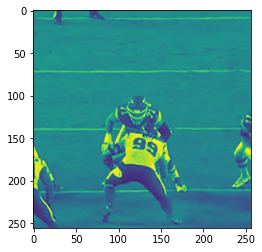

2948

In [16]:
img, feature, label = MyDataset(test_filtered, valid_aug, 'test')[0]
plt.imshow(img.permute(1,2,0)[:,:,7])
plt.show()
img.shape, feature, label
gc.collect()

In [17]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.backbone = timm.create_model(CFG['model'], pretrained=False, num_classes=500, in_chans=13)
        self.mlp = nn.Sequential(
            nn.Linear(18, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            # nn.Linear(64, 64),
            # nn.LayerNorm(64),
            # nn.ReLU(),
            # nn.Dropout(0.2)
        )
        self.fc = nn.Linear(64+500*2, 1)

    def forward(self, img, feature):
        b, c, h, w = img.shape
        img = img.reshape(b*2, c//2, h, w)
        img = self.backbone(img).reshape(b, -1)
        feature = self.mlp(feature)
        y = self.fc(torch.cat([img, feature], dim=1))
        return y

In [18]:
test_set = MyDataset(test_filtered, valid_aug, 'test')
test_loader = DataLoader(test_set, batch_size=CFG['valid_bs'], shuffle=False, num_workers=CFG['num_workers'], pin_memory=True)

model = Model().to(device)
model.load_state_dict(torch.load('/kaggle/input/nfl-exp1/resnet50_fold0.pt'))

model.eval()
    


Model(
  (backbone): ResNet(
    (conv1): Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, mome

In [19]:
y_pred = []
with torch.no_grad():
    tk = tqdm(test_loader, total=len(test_loader))
    for step, batch in enumerate(tk):
        if(step % 4 != 3):
            img, feature, label = [x.to(device) for x in batch]
            output1 = model(img, feature).squeeze(-1)
            output2 = model(img.flip(-1), feature).squeeze(-1)
            
            y_pred.extend(0.1*(output1.sigmoid().cpu().numpy()) + 0.7*(output2.sigmoid().cpu().numpy()))
        else:
            img, feature, label = [x.to(device) for x in batch]
            output = model(img.flip(-1), feature).squeeze(-1)
            y_pred.extend(output.sigmoid().cpu().numpy())    

y_pred = np.array(y_pred)

100%|██████████| 104/104 [16:42<00:00,  9.64s/it]


In [20]:
th = 0.29

test_filtered['contact'] = (y_pred >= th).astype('int')

sub = pd.read_csv('/kaggle/input/nfl-player-contact-detection/sample_submission.csv')

sub = sub.drop("contact", axis=1).merge(test_filtered[['contact_id', 'contact']], how='left', on='contact_id')
sub['contact'] = sub['contact'].fillna(0).astype('int')

sub[["contact_id", "contact"]].to_csv("submission.csv", index=False)

sub.head()

contact_id  contact
0  58168_003392_0_38590_43854        0
1  58168_003392_0_38590_41257        0
2  58168_003392_0_38590_41944        0
3  58168_003392_0_38590_42386        0
4  58168_003392_0_38590_47944        0

In this competition, my task is to predict moments of contact between player pairs, as well as when players make non-foot contact with the ground using game footage and tracking data. Each play has four associated videos. Two videos, showing a sideline and endzone view, are time synced and aligned with each other. Additionally, an All29 view is provided but not guaranteed to be time synced. The training set videos are in train/ with corresponding labels in train_labels.csv, while the videos for which you must predict are in the test/ folder.

This year we are also providing baseline helmet detection and assignment boxes for the training and test set. train_baseline_helmets.csv is the output from last year's winning player assignment model.